This is an example script for running the microcircuit model and generating basic plots of the network activity.

Import the necessary modules and start the time measurements.

In [1]:
import time
import nest
import network
import addons
import helpers
import numpy as np
import pandas as pd 
from network_params import net_dict
from sim_params import sim_dict
from stimulus_params import stim_dict

time_start = time.time()


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: Apr 15 2024 07:21:32

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



Initialize the network with simulation, network and stimulation parameters, then create and connect all nodes, and finally simulate. The times for a presimulation and the main simulation are taken independently. A presimulation is useful because the spike activity typically exhibits a startup transient. In benchmark simulations, this transient should be excluded from a time measurement of the state propagation phase. Besides, statistical measures of the spike activity should only be computed after the transient has passed.

In [2]:
net = network.Network(sim_dict, net_dict, stim_dict)
time_network = time.time()

net.create()
time_create = time.time()

Data will be written to: /home/hyc_1/CorticalColumn_Github_1/CorticalColumn_Attempts/data_og/
  Directory already existed. Old data will be overwritten.


RNG seed: 55
Total number of virtual processes: 10
Creating neuronal populations.

Jan 13 16:36:08 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.
Creating recording devices.
  Creating spike recorders.
  Creating voltmeters.
Creating ammeters.
Creating ammeters.
Creating Poisson generators for background input.
Creating thalamic input for external stimulation.


In [3]:
net.connect()
time_connect = time.time()

Connecting neuronal populations recurrently.
NodeCollection(metadata=None, model=iaf_psc_exp, size=20683, first=1, last=20683)
NodeCollection(metadata=None, model=iaf_psc_exp, size=5834, first=20684, last=26517)
NodeCollection(metadata=None, model=iaf_psc_exp, size=21915, first=26518, last=48432)
NodeCollection(metadata=None, model=iaf_psc_exp, size=5479, first=48433, last=53911)
NodeCollection(metadata=None, model=iaf_psc_exp, size=4850, first=53912, last=58761)
NodeCollection(metadata=None, model=iaf_psc_exp, size=1065, first=58762, last=59826)
NodeCollection(metadata=None, model=iaf_psc_exp, size=14395, first=59827, last=74221)
NodeCollection(metadata=None, model=iaf_psc_exp, size=2948, first=74222, last=77169)
Connecting Poisson generators for background input.
Connecting thalamic input.

Jan 13 16:36:27 NodeManager::prepare_nodes [Info]: 
    Preparing 78079 nodes for simulation.


In [4]:
### Let's attempt to get the number of connections that go into the first 500 neurons of each population
data_synapses = addons.number_synapses(net.pops)

 pop: 0 
 neuron: 50 Mean:[3428.32 1554.26]Standard deviation:[63.56459392 44.19719901]Maximum:[3553 1633]Minimum:[3257 1450]
 pop: 1 
 neuron: 20733 Mean:[4148.6  1157.06]Standard deviation:[60.16975985 29.70818742]Maximum:[4293 1221]Minimum:[4031 1071]
 pop: 2 
 neuron: 26567 Mean:[1974.66  887.18]Standard deviation:[48.26825458 31.75134013]Maximum:[2116  949]Minimum:[1898  789]
 pop: 3 
 neuron: 48482 Mean:[4917.4  1001.68]Standard deviation:[60.37482919 30.70207811]Maximum:[5034 1081]Minimum:[4791  908]
 pop: 4 
 neuron: 53961 Mean:[4017.92  907.14]Standard deviation:[63.4015268  32.36974513]Maximum:[4156 1009]Minimum:[3885  852]
 pop: 5 
 neuron: 58811 Mean:[2169.74  580.92]Standard deviation:[41.27702024 21.36056179]Maximum:[2241  628]Minimum:[2064  532]
 pop: 6 
 neuron: 59876 Mean:[1653.68  937.42]Standard deviation:[38.41637151 32.64971057]Maximum:[1741 1008]Minimum:[1564  859]
 pop: 7 
 neuron: 74271 Mean:[1966.92  487.64]Standard deviation:[38.79940206 22.52621584]Maximum:[2

In [5]:
net.simulate(sim_dict["t_presim"])
time_presimulate = time.time()

Simulating 500.0 ms.

Jan 13 16:38:13 NodeManager::prepare_nodes [Info]: 
    Preparing 78079 nodes for simulation.

Jan 13 16:38:13 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 78079
    Simulation time (ms): 500
    Number of OpenMP threads: 10
    Number of MPI processes: 1

Jan 13 16:38:39 SimulationManager::run [Info]: 
    Simulation finished.


In [6]:
net.simulate(sim_dict["t_sim"])
time_simulate = time.time()

Simulating 5000.0 ms.

Jan 13 16:38:39 NodeManager::prepare_nodes [Info]: 
    Preparing 78079 nodes for simulation.

Jan 13 16:38:39 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 78079
    Simulation time (ms): 5000
    Number of OpenMP threads: 10
    Number of MPI processes: 1

Jan 13 16:44:18 SimulationManager::run [Info]: 
    Simulation finished.


Plot a spike raster of the simulated neurons and a box plot of the firing rates for each population. For visual purposes only, spikes 100 ms before and 100 ms after the thalamic stimulus time are plotted here by default. The computation of spike rates discards the presimulation time to exclude initialization artifacts.

Interval to plot spikes: [600 800] ms
Interval to compute firing rates: [ 500 2500] ms
Mean rates: [0.038 0.951 1.213 5.326 1.72  6.42  0.918 6.939] spikes/s
Standard deviation of rates: [0.147 0.925 1.299 3.336 1.596 3.533 1.2   4.122] spikes/s


/usr/lib/python3/dist-packages/matplotlib/ticker.py:2788: RuntimeWarning:invalid value encountered in log10


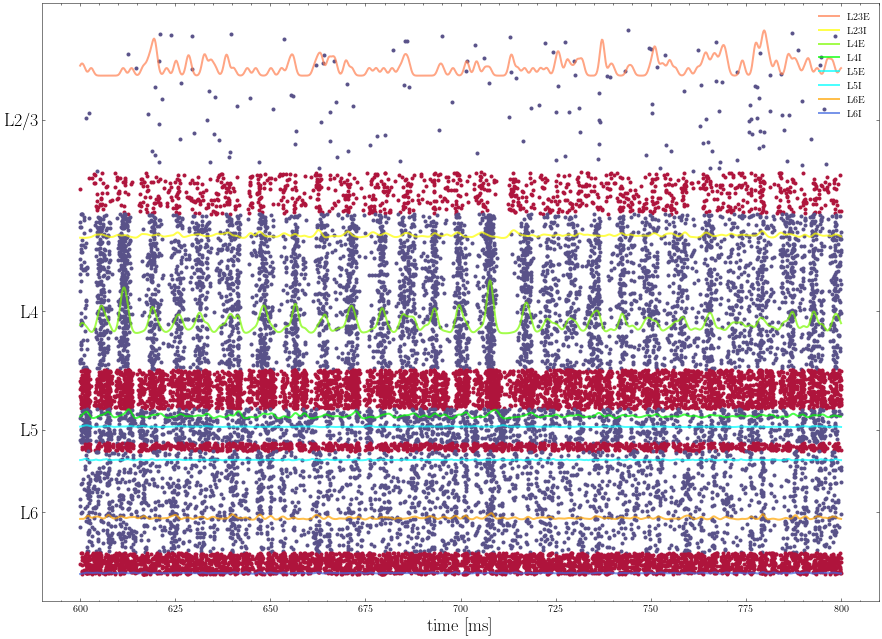

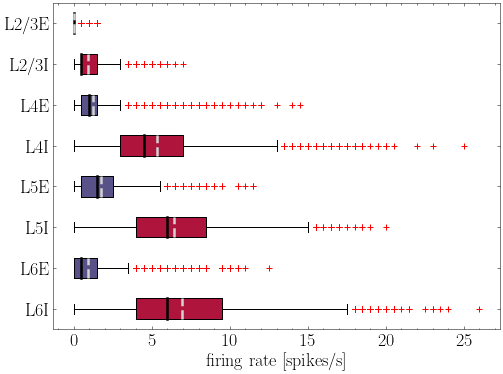

In [7]:
raster_plot_interval = np.array([600, 800])
firing_rates_interval = np.array([500,2500])
pop_activity = net.evaluate(raster_plot_interval, firing_rates_interval,binned=True)
time_evaluate = time.time()